Here is my assignment 1, this is the notebook pdf, the code is on github at this link : https://github.com/CrazierThanYou/FYS-2021/tree/6cc2c8bb9fe3136c4e84736a2248a5fc39a16005/Assigments/Assigment1. Tim THIEFFENAT

In [271]:
import numpy as np
import pandas as pd
import math as m
import matplotlib.pyplot as plt 

np.set_printoptions(precision=4, suppress=True)

To get the number of tracks and the number of features we can use the method shape, it give us the size of the table, of course we have to subtract one to the track because the first row is the label of the features.

In [272]:
table = pd.read_csv('./SpotifyFeatures.csv')
nb_track, nb_feature = table.shape
print("tracks =", nb_track, "\nFeatures =", nb_feature)

tracks = 232725 
Features = 18


We need to reshape the table to get only the information we need, so only Pop and Classical tracks, and only the features "genre", "liveness" and "loudness". For that we first do a loop to filter on the genre, and then just keep the columns we need.

In [273]:
# List for the tracks pop and classical
filter_track =[]

# Loop to find the tracks and to change their genre to integer
for index, track in table.iterrows():
    if track["genre"] == "Pop":
        track["genre"] = 1
        filter_track.append(track)
    if track["genre"] == "Classical":
        track["genre"] = 0
        filter_track.append(track)

# Creating the new table
new_table = pd.DataFrame(filter_track, columns=["genre", "liveness", "loudness"])
print(new_table)

# Keeping tracks artist and name if we want to know it later
track_table = pd.DataFrame(filter_track, columns=["artist_name", "track_name"])

        genre  liveness  loudness
104022      0    0.0762   -21.356
104023      0    0.1060   -34.255
104024      0    0.0916   -28.215
104025      0    0.1730   -37.264
104026      0    0.0858   -35.213
...       ...       ...       ...
167297      0    0.0776   -25.477
167298      0    0.2450   -28.192
167299      0    0.0816   -25.843
167300      0    0.1050   -20.238
167301      0    0.0953   -29.223

[18642 rows x 3 columns]


Next step is to split the data, to do so and keeping the classes distribution, we need to first sort the data, then split the data class by class.

In [274]:
# Creating the new arrays and sorting it to split the data per classes
np_table = new_table.to_numpy()
np_track_table = track_table.to_numpy()

# Shuffle the tracks to add random (but still keeping the same order in the np_table and the np_track_table)
shuffle_index = np.random.permutation(np_table.shape[0])
np_table = np_table[shuffle_index]
np_track_table = np_track_table[shuffle_index]

# Sorting the tracks by classes (still shuffled inside classes)
sorted_index = np.argsort(np_table[:, 0])
np_table = np_table[sorted_index]
np_track_table = np_track_table[sorted_index]

input = np_table[:, 1:]
target = np_table[:, 0]

# Finding the number of pop and classical track to slit 80/20
nb_pop = 0
nb_classical = 0
for track in target:
    if track:
        nb_pop += 1
    else:
        nb_classical += 1

print("Number of classical tracks =", nb_classical, "\nNumber of pop tracks =", nb_pop)

# Splitting the data
input_train = np.concatenate([input[:int(nb_classical*0.8)], input[nb_classical:(nb_classical + int(nb_pop*0.8))]])
input_test = np.concatenate([input[int(nb_classical*0.8):(nb_classical)], input[nb_classical  + int(nb_pop*0.8):]])
target_train = np.concatenate([target[:int(nb_classical*0.8)], target[nb_classical:(nb_classical + int(nb_pop*0.8))]])
target_test = np.concatenate([target[int(nb_classical*0.8):(nb_classical)], target[nb_classical + int(nb_pop*0.8):]])

# Verifying the split
nb_pop_train = 0
nb_classical_train = 0
for track in target_train:
    if track:
        nb_pop_train += 1
    else:
        nb_classical_train += 1

print("Number of classical tracks train =", nb_classical_train, "\nNumber of pop tracks train =", nb_pop_train)

nb_pop_test = 0
nb_classical_test = 0
for track in target_test:
    if track:
        nb_pop_test += 1
    else:
        nb_classical_test += 1

print("Number of classical tracks test =", nb_classical_test, "\nNumber of pop tracks test =", nb_pop_test)

print("Number of classical tracks test + train =", (nb_classical_test + nb_classical_train) , "\nNumber of pop tracks test + train =", (nb_pop_test + nb_pop_train))

Number of classical tracks = 9256 
Number of pop tracks = 9386
Number of classical tracks train = 7404 
Number of pop tracks train = 7508
Number of classical tracks test = 1852 
Number of pop tracks test = 1878
Number of classical tracks test + train = 9256 
Number of pop tracks test + train = 9386


We can see here that the number of classical tracks test + train is the same as the total number of classical tracks, that means we use all the tracks between the training and the testing, but also that there are no tracks used in both. Same for the pop tracks.
We can also verify the 80/20 distribution between training and testing.

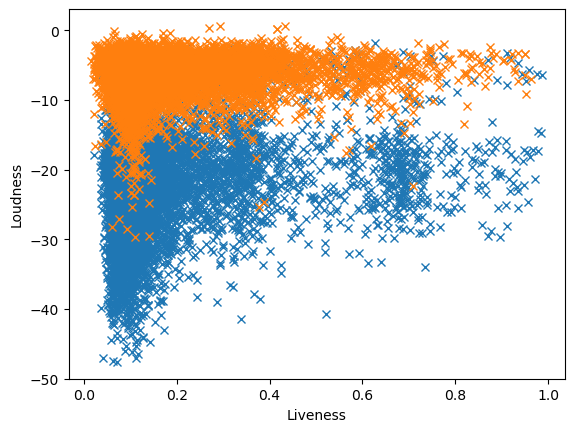

In [275]:
# Plotting the data
liveness_classical = input[:nb_classical, 0]
loudness_classical = input[:nb_classical, 1]
plt.plot(liveness_classical, loudness_classical, 'x')

liveness_pop = input[nb_classical:, 0]
loudness_pop = input[nb_classical:, 1]
plt.plot(liveness_pop, loudness_pop, 'x')

plt.xlabel("Liveness")
plt.ylabel("Loudness")
plt.show()

It will be impossible to classify them perfectly because the distribution are overlapping, but we could do something correct enough. Maybe if we add an other feature we could have better results.

Next we need to implement the logistic discrimination classifier, to do so, i will first implement the loss function, his derivative and an accuracy function

In [276]:
def loss(output, target):
    loss = 0
    for i in range(0,output.shape[0]):
        if target[i] == 0:
            loss += - m.log10(1 - output[i] + 1e-10)
        else:
            loss += - m.log10(output[i] + 1e-10)
    return loss

def derivative_loss(input, output, target):
    temp = np.hstack((input,np.ones((input.shape[0], 1))))
    return (temp.transpose() @ (output - target))

def accuracy(output, target):
    accuracy = 0
    for i in range(0,output.shape[0]):
        if round(output[i]) == target[i]:
            accuracy += 1
    accuracy = accuracy/output.shape[0]
    return accuracy

Now i will use a new class to do the classifier. The attributes of this class will be the slopes (as there are 2 input here there are 2 slopes),the intercept,the learning rate, the number of epoch and the list of the losses. The methods will be test() and train(). The slop and the intercept will be only vector as we can add ones to the input and take the intercept as a slope for those ones.

In [277]:
class Classifier:
    def __init__(self, learning_rate, nb_epoch, loss, derivative_loss):
        self.parameters = np.ones((1,3))
        self.learning_rate = learning_rate
        self.nb_epoch = nb_epoch
        self.losses = []
        self.loss = loss
        self.derivative_loss = derivative_loss

    def test(self, input):
        temp = self.parameters @ (np.hstack((input,np.ones((input.shape[0], 1))))).transpose()
        output = 1 / ( 1 + np.exp(-temp[0]))
        return output
    
    def train(self, input, target):
        for i in range(0, self.nb_epoch):
            shuffle_index = np.random.permutation(input.shape[0])
            input_shuffled = input[shuffle_index]
            target_shuffled = target[shuffle_index]
            output = self.test(input_shuffled)
            self.losses.append(self.loss(output, target_shuffled))
            d_loss = self.derivative_loss(input_shuffled, output, target_shuffled)
            self.parameters = self.parameters - self.learning_rate * d_loss

    def plot_loss(self):
        plt.plot(range(0,self.nb_epoch), self.losses)
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.grid("true")
        plt.show()

And finally we can use our classifier on our data, and test the accuracy.

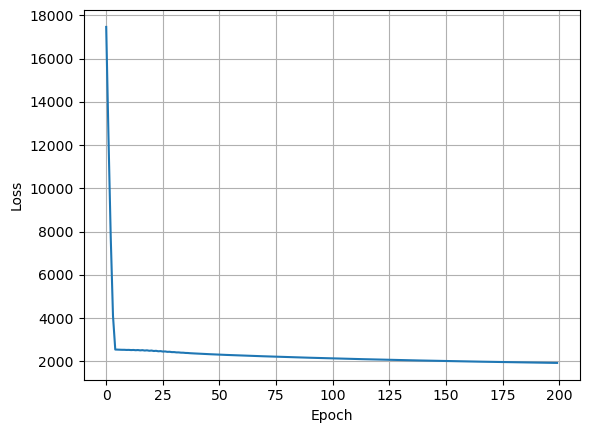

The accuracy of the classifier on the train set is 91.91925965665236 %
The accuracy of the classifier on the test set is 92.5201072386059 %


In [278]:
# Definition of the hyperparameters
classifier = Classifier(0.000005, 200, loss, derivative_loss)

# Training
classifier.train(input_train, target_train)
classifier.plot_loss()

# Testing
output_train = classifier.test(input_train)
acc = accuracy(output_train, target_train)
print("The accuracy of the classifier on the train set is", acc * 100, "%")
output_test = classifier.test(input_test)
acc = accuracy(output_test, target_test)
print("The accuracy of the classifier on the test set is", acc * 100, "%")

The accuracy is 91.8% on the training set which is good, it is slightly bigger on the training set, it is normal but there isn't a great difference because the data are well shuffle.
The loss is decreasing really fast at the beginning and the it start to stabilize, we could do more epochs but the loss won't decrease much and it will take much more time. So at chose to stop a 200 epochs. We can also see that the learning rate is good because if we try a bigger learning rate, the loss start oscillating around the minimum, that means the rate is too big. Here is an example with a bigger learning rate:

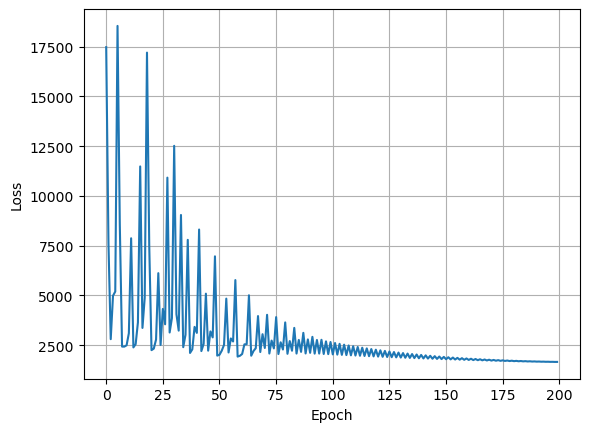

The accuracy of the classifier is 92.81501340482575 %


In [279]:
# Definition of the hyperparameters
classifier = Classifier(0.00001, 200, loss, derivative_loss)

# Training
classifier.train(input_train, target_train)
classifier.plot_loss()

# Testing
output_test = classifier.test(input_test)
acc = accuracy(output_test, target_test)
print("The accuracy of the classifier is", acc * 100, "%")

We can plot the line that our model found between pop and classical.

1.3013848628068971 0.29533668450707157 3.3787531155151123


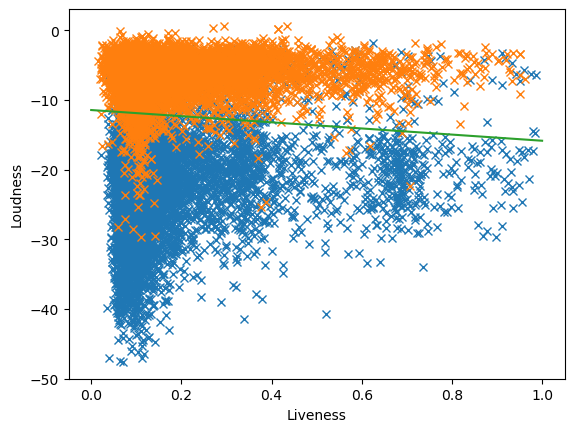

In [280]:
# Plotting the data
liveness_classical = input[:nb_classical, 0]
loudness_classical = input[:nb_classical, 1]
plt.plot(liveness_classical, loudness_classical, 'x')

liveness_pop = input[nb_classical:, 0]
loudness_pop = input[nb_classical:, 1]
plt.plot(liveness_pop, loudness_pop, 'x')

#Plotting the classifier
a1, a2, b = classifier.parameters[0]
liveness_line = np.linspace(0, 1, 1000)
loudness_line = - (liveness_line * a1 + b) / a2
plt.plot(liveness_line, loudness_line)

plt.xlabel("Liveness")
plt.ylabel("Loudness")

plt.show()

Now we can do the confusion matrix to see how good our classifier is, for that we can just do a loop, same as accuracy but counting all true positive, true negative, false positive and false negative.

In [281]:
def confusion(output, target):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for i in range(0,output.shape[0]):
        if(round(output[i])):
            if(target[i]):
                tp += 1
            else:
                fp += 1
        else:
            if(target[i]):
                fn += 1
            else:
                tn += 1
    return np.array([[tp, fn], [fp, tn]])

And now we can try our confusion matrix on our test of the classifier.

In [282]:
print("Confusion matrix :\n", confusion(output_test, target_test))

Confusion matrix :
 [[1809   69]
 [ 199 1653]]


There are a lot of false positive, more than false negative, that means a lot of pop tracks are classify as classical tracks. It can be explain by the fact that pop tracks cover a lot more diversity in term of liveness and loudness than classical tracks, that's why a lot of them are misclassify.

The confusion matrix give us more information than the accuracy, as it tells us exactly what are the mistakes, if the tracks that are misclassify are more pop tracks or classical tracks, and same for the well classify tracks, so we can adjust our classifier to consider that. For example in situation where we want really few false negative, in medical tests for example, we could know exactly how many false negative there are and we can adjust as we want.

If we want some classical songs that a pop fan would like, we can adjust the loss function, add weight to make our classifier give us less false positive, so less classical tracks that are classify as pop tracks, but those ones will be the ones that a pop fan would love.

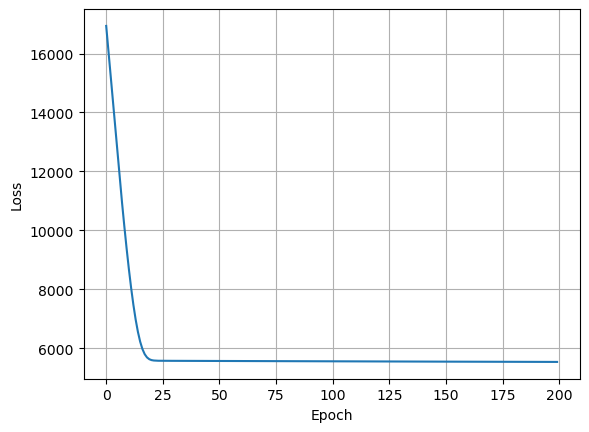

The accuracy of the classifier on the test set is 62.546916890080425 %
Confusion matrix :
 [[ 534 1344]
 [  53 1799]]


In [283]:
# Definition of a weight loss
def weight_loss(output, target):
    loss = 0
    for i in range(0,output.shape[0]):
        if target[i] == 0:
            loss += - 10 * m.log10(1 - output[i] + m.exp(-10))
        else:
            loss += - m.log10(output[i] + m.exp(-10))
    return loss

def weight_derivative_loss(input, output, target):
    temp = np.hstack((input,np.ones((input.shape[0], 1))))
    error = (output - target)
    for i in range(0,output.shape[0]):
        if target[i] == 0:
            error[i] = error[i] * 10
    return (temp.transpose() @ error)

# Definition of the hyperparameters
classifier = Classifier(0.000001, 200, weight_loss, weight_derivative_loss)

# Training
classifier.train(input_train, target_train)
classifier.plot_loss()

# Testing
output_test = classifier.test(input_test)
acc = accuracy(output_test, target_test)
print("The accuracy of the classifier on the test set is", acc * 100, "%")

print("Confusion matrix :\n", confusion(output_test, target_test))

Of course the accuracy will not be as good as before but if we look at the confusion matrix, there will be a lot less false positive, and we could even get the list to give it to a pop fan. Those songs are the few orange point under the green line.

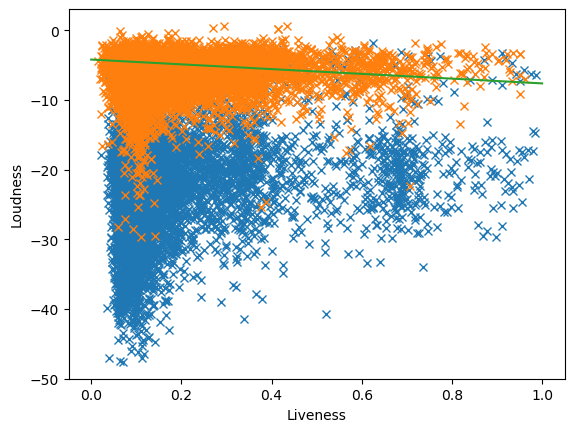

In [284]:
# Plotting the data
liveness_classical = input[:nb_classical, 0]
loudness_classical = input[:nb_classical, 1]
plt.plot(liveness_classical, loudness_classical, 'x')

liveness_pop = input[nb_classical:, 0]
loudness_pop = input[nb_classical:, 1]
plt.plot(liveness_pop, loudness_pop, 'x')

#Plotting the classifier
a1, a2, b = classifier.parameters[0]
liveness_line = np.linspace(0, 1, 1000)
loudness_line = - (liveness_line * a1 + b) / a2
plt.plot(liveness_line, loudness_line)

plt.xlabel("Liveness")
plt.ylabel("Loudness")

plt.show()

In [285]:
# Giving the classifier every song
output = classifier.test(input)

# Listing those who are false positive (we never modify the input, so it is in the the order as our tracks tables !)
false_negative = []
for i in range(0,output.shape[0]):
        if(round(output[i])):
            if(target[i] == 0):
                false_negative.append(np_track_table[i])

'If I Could Fly' and 'Starry Night' by Joe Satriani are the music i would recommended, Satriani is a really good guitarist.